In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
import datetime
import os, sys
import networkx as nx


from scipy.linalg import eigh
import scipy

sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
#sys.path.insert(0, 'C:/Users/Ragnar/Documents/git_code/MMDGraph')
import covariance
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['covariance'])

import mmdutils
importlib.reload(sys.modules['mmdutils'])

import mgarch

In [2]:
min_date = '2004-01-01 04:00:00'
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > min_date, price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]


# Create dictionary to store which company belongs to which sector
sector_classification = dict()
for i in range(asset_profiles.shape[0]):
    if asset_profiles['sector'].iloc[i] not in sector_classification.keys():
        sector_classification[asset_profiles['sector'].iloc[i]] = list()
    sector_classification[asset_profiles['sector'].iloc[i]].append(asset_profiles['ticker'].iloc[i])
    
price_pivot

ticker,NUE,MOS,FMC,VMC,NEM,IFF,FCX,ALB,LYB,MLM,...,AWK,DTE,DUK,ATO,ED,EIX,LNT,PEG,WEC,ETR
date,,,,,,,,,,,,,,,,,,,,,
2004-01-05,0.021184,0.046697,0.000584,0.059615,0.022564,0.038504,0.047528,0.006590,NaN,0.014951,...,NaN,-0.005332,-0.001475,-0.008936,-0.006536,-0.006863,0.002816,-0.009174,-0.004195,-0.010712
2004-01-06,0.003140,-0.029289,0.004948,-0.010230,-0.018461,-0.007019,-0.020691,-0.000328,NaN,0.038470,...,NaN,-0.004338,-0.014375,-0.007782,-0.000469,0.007319,0.002408,0.001611,0.000300,-0.001061
2004-01-07,-0.035086,0.023687,-0.000581,0.002015,-0.029084,0.001970,0.001161,0.001641,NaN,0.016991,...,NaN,-0.004099,0.056769,0.006149,0.005142,0.003186,0.009176,0.002987,0.000000,0.006518
2004-01-08,0.018582,0.090361,0.017567,-0.015819,0.009650,0.002809,0.014969,-0.000656,NaN,0.006198,...,NaN,-0.000514,-0.016167,0.008141,-0.001633,-0.000454,-0.000397,0.014572,0.003894,0.005777
2004-01-09,-0.001594,-0.071807,-0.026908,0.005504,0.014919,-0.003934,0.015874,-0.022234,NaN,-0.011830,...,NaN,-0.005926,-0.007217,-0.004877,0.001166,0.002723,-0.016423,-0.005213,-0.006599,-0.009119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-14,0.008831,0.016074,0.034795,0.033456,0.024533,0.027131,0.038015,0.033718,0.021069,0.040133,...,0.010453,0.009518,0.009390,0.018696,-0.005009,0.003185,0.012187,0.020399,0.010286,0.008930
2021-10-15,0.005418,0.001931,0.010001,0.003680,-0.012892,-0.005002,0.039863,-0.011128,0.007800,0.006886,...,0.001401,-0.000174,-0.012871,-0.010057,-0.015985,0.013164,-0.006612,0.011334,0.001889,-0.011958
2021-10-18,0.007342,0.009599,-0.004336,0.020198,-0.011463,-0.014057,-0.002591,0.034963,-0.006885,0.021903,...,-0.006027,-0.011629,-0.004895,-0.020642,-0.021445,-0.003318,-0.007921,-0.006137,-0.013750,-0.004705


In [3]:
sector_classification

{'Industrials': ['MMM',
  'ALK',
  'ALLE',
  'AAL',
  'AME',
  'AOS',
  'ADP',
  'AVY',
  'BA',
  'CHRW',
  'CARR',
  'CAT',
  'CTAS',
  'CPRT',
  'CSX',
  'CMI',
  'DE',
  'DAL',
  'DOV',
  'ETN',
  'EMR',
  'EFX',
  'EXPD',
  'FAST',
  'FDX',
  'GNRC',
  'GD',
  'GE',
  'GPN',
  'GWW',
  'HON',
  'HWM',
  'HII',
  'IEX',
  'INFO',
  'ITW',
  'IR',
  'J',
  'JBHT',
  'JCI',
  'KSU',
  'LHX',
  'LMT',
  'MAS',
  'NLSN',
  'NSC',
  'NOC',
  'ODFL',
  'OTIS',
  'PCAR',
  'PH',
  'PAYX',
  'PNR',
  'PWR',
  'RTX',
  'RSG',
  'RHI',
  'ROK',
  'ROP',
  'SNA',
  'LUV',
  'SWK',
  'TXT',
  'TT',
  'TDG',
  'UNP',
  'UAL',
  'UPS',
  'URI',
  'VRSK',
  'WAB',
  'WM',
  'XYL'],
 'Healthcare': ['ABT',
  'ABBV',
  'ABMD',
  'A',
  'ALGN',
  'ABC',
  'AMGN',
  'ANTM',
  'BAX',
  'BDX',
  'BIO',
  'TECH',
  'BIIB',
  'BSX',
  'BMY',
  'CAH',
  'CTLT',
  'CNC',
  'CERN',
  'CRL',
  'CI',
  'COO',
  'CVS',
  'DHR',
  'DVA',
  'XRAY',
  'DXCM',
  'EW',
  'GILD',
  'HCA',
  'HSIC',
  'HOLX',
  'HUM',


In [4]:
x = price_pivot.loc[price_pivot.index > datetime.datetime.strptime('2021-06-01', '%Y-%d-%m').date()]
x = x.dropna(axis = 1)
x = x.iloc[:, :10]

ticker,NUE,MOS,FMC,VMC,NEM,IFF,FCX,ALB,LYB,MLM,...,AWK,DTE,DUK,ATO,ED,EIX,LNT,PEG,WEC,ETR
date,,,,,,,,,,,,,,,,,,,,,
2021-01-07,-0.014663,0.032480,0.014795,0.007745,-0.001534,0.049498,0.032940,0.049579,0.007208,0.016905,...,-0.001511,-0.024619,-0.011283,-0.042954,-0.020529,-0.009144,-0.037763,-0.014335,-0.033097,-0.035121
2021-01-08,-0.003030,-0.003723,-0.006585,0.005049,-0.036743,0.002945,-0.000642,0.000543,-0.007414,0.008443,...,0.031383,-0.004811,0.001778,-0.005697,0.000286,0.004021,0.004875,0.021339,-0.003519,0.006830
2021-01-11,0.013827,-0.001493,-0.014224,0.001043,-0.013468,0.028579,-0.027007,-0.037692,0.002374,-0.001193,...,-0.002168,-0.001778,-0.008476,-0.017974,-0.017309,-0.010164,-0.016344,-0.005775,-0.011320,-0.011586
2021-01-12,0.022629,0.061218,0.023840,0.019442,0.008679,0.028420,0.021857,0.028963,0.022734,0.015203,...,-0.002621,0.010791,-0.004040,-0.000571,-0.011855,0.013529,-0.010768,0.006473,-0.019626,-0.018067
2021-01-13,-0.024215,-0.012730,-0.002703,-0.028068,-0.006744,-0.036044,-0.013973,-0.014238,-0.021086,-0.031559,...,0.021905,0.021321,0.029145,0.009541,0.024578,0.010978,0.014879,0.022926,0.029922,0.010196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-14,0.008831,0.016074,0.034795,0.033456,0.024533,0.027131,0.038015,0.033718,0.021069,0.040133,...,0.010453,0.009518,0.009390,0.018696,-0.005009,0.003185,0.012187,0.020399,0.010286,0.008930
2021-10-15,0.005418,0.001931,0.010001,0.003680,-0.012892,-0.005002,0.039863,-0.011128,0.007800,0.006886,...,0.001401,-0.000174,-0.012871,-0.010057,-0.015985,0.013164,-0.006612,0.011334,0.001889,-0.011958
2021-10-18,0.007342,0.009599,-0.004336,0.020198,-0.011463,-0.014057,-0.002591,0.034963,-0.006885,0.021903,...,-0.006027,-0.011629,-0.004895,-0.020642,-0.021445,-0.003318,-0.007921,-0.006137,-0.013750,-0.004705


# Scola estimation of one 

In [36]:
C_samp = np.corrcoef(np.array(x).T)

lamda, v = np.linalg.eigh(C_samp)
v = np.fliplr(v)
lamda = np.flipud(lamda)

C_null = lamda[0]* np.outer(v[:, 0], v[:, 0]) # np.identity(C_samp.shape[0]) #

L = x.shape[0]

# Select a sector and create a network out of it

In [59]:
index = np.array(range(x.shape[1]))
i_sector = index[x.columns.isin(sector_classification['Industrials'])]
C_samp_sector = C_samp[np.ix_(i_sector, i_sector)]
C_null_sector = C_null[np.ix_(i_sector, i_sector)]
x_sector = np.array(x)[:,i_sector]
print(x_sector.shape)
C_samp_sector.shape

(110, 73)


(73, 73)

In [42]:
importlib.reload(sys.modules['mmdutils'])
importlib.reload(sys.modules['my_scola'])
tt = my_scola.Scola()
for l in np.linspace(0, 1,100):
    W = tt.detect(C_samp_sector, C_null_sector, l)
    print(f'{l} {mmdutils._comp_EBIC(W, C_samp_sector, C_null_sector, x.shape[0], 0.5, 0, "cov")} {mmdutils._comp_loglikelihood(W,C_samp_sector, C_null_sector, "cov")}')

0.0 47659.917611311685 -57.98363812424216
0.010101010101010102 19617.14468754198 -63.57196093796436
0.020202020202020204 21585.31886089365 -84.77331648666336
0.030303030303030304 21058.427079749094 -91.31311333926628
0.04040404040404041 24165.46253708046 -105.4360017816816
0.05050505050505051 21508.2732209037 -95.35007841354604
0.06060606060606061 17247.716248656292 -77.01020029977381
0.07070707070707072 16855.21633023497 -75.28647975807729
0.08080808080808081 16775.259079807103 -75.1645176970068
0.09090909090909091 15570.873115245888 -69.87114602965704
0.10101010101010102 16673.915264089886 -74.76423398578349
0.11111111111111112 15881.090804528414 -71.64344641498005
0.12121212121212122 16066.159184176306 -72.66577631221713
0.13131313131313133 16357.601491905612 -73.74903408829418
0.14141414141414144 18554.93065849954 -83.91800392619507
0.15151515151515152 16843.121557178023 -76.19742346222495
0.16161616161616163 15750.095587695276 -71.34986359410418
0.17171717171717174 16418.209250359

In [ ]:
 W = tt.detect(C_samp_sector, C_null_sector, 0.28)
 mmdutils.plot_corr(W)
 np.sum(W, axis = 1)

In [83]:
importlib.reload(sys.modules['mmdutils'])
importlib.reload(sys.modules['my_scola'])
importlib.reload(sys.modules['gradient_descent'])
tt = my_scola.Scola(likelihood='mvt')
for l in np.linspace(0, 1,100):
    W = tt.detect(C_samp_sector, C_null_sector, l, x = np.array(x_sector))
    print(f'{l} {mmdutils._comp_EBIC(W, C_samp_sector, C_null_sector, x.shape[0], 0.5, 0, "cov")} {mmdutils._comp_loglikelihood(W,C_samp_sector, C_null_sector, "cov")}')

0
0
0
0


C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\my_scola.py:61: RuntimeWarning: invalid value encountered in log
  


0
0
0
0
0
0
0
0
0.0 41684.95139533405 -30.82470077888923
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.010101010101010102 17394.97991584699 -45.56274242344312
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.020202020202020204 14756.061004162251 -46.42646573325339
0
0


KeyboardInterrupt: 

0
0
0
0
0
0
0
0

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\my_scola.py:61: RuntimeWarning: invalid value encountered in log
  l = L * np.log(gamma((nu + p)/2.0)) - L * np.log(gamma(nu / 2.0)) - L * (p/2.0) * np.log(nu) - L * (p/2.0) * np.log(p) - L * 0.5 * np.sum(np.log(w)) + L * np.log(nu) - ((nu + p) / 2.0) * np.sum(np.log(nu + nu * d))



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<AxesSubplot:>

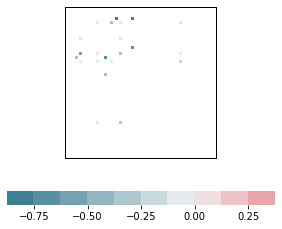

In [84]:
 importlib.reload(sys.modules['my_scola'])
 W = tt.detect(C_samp_sector, C_null_sector, 0.08, x = np.array(x_sector))
 mmdutils.plot_corr(W)
 #np.sum(W, axis = 1)

# DCC-GARCH

In [5]:
importlib.reload(sys.modules['mgarch'])
vol = mgarch.mgarch()
vol.fit(np.array(x))

starting garch
0 / 502
10 / 502
20 / 502


KeyboardInterrupt: 

# ASDF